In [55]:
# 필수 Package import
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [57]:
# 이미지를 출력하는 함수
def display_images(image_paths, title, max_images=4):
    """지정된 경로의 이미지를 최대 4개까지 출력합니다."""
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

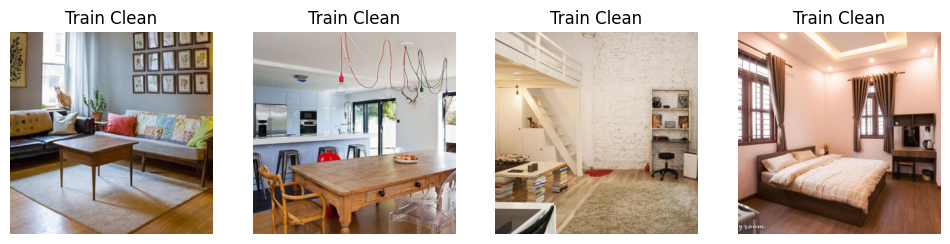

Train Clean 총 이미지 수: 96


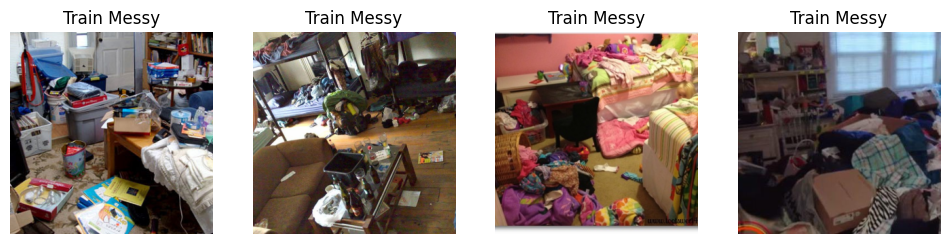

Train Messy 총 이미지 수: 96


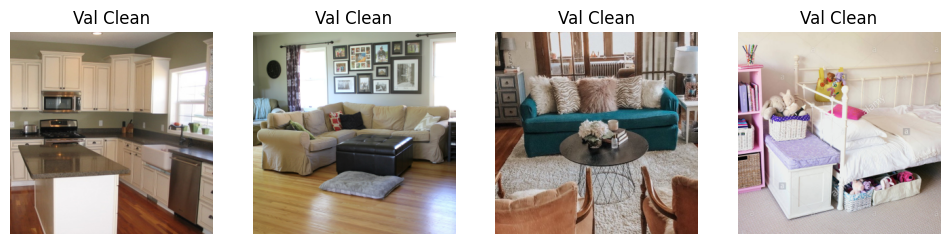

Val Clean 총 이미지 수: 10


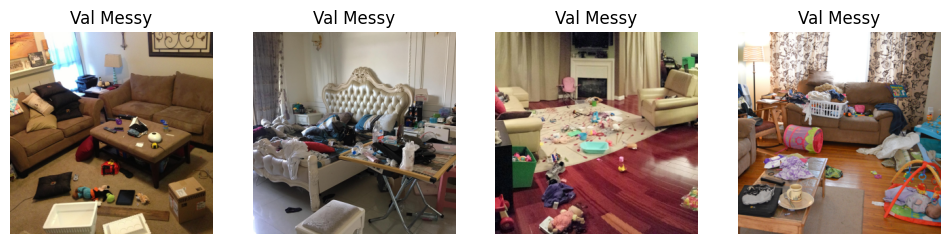

Val Messy 총 이미지 수: 10


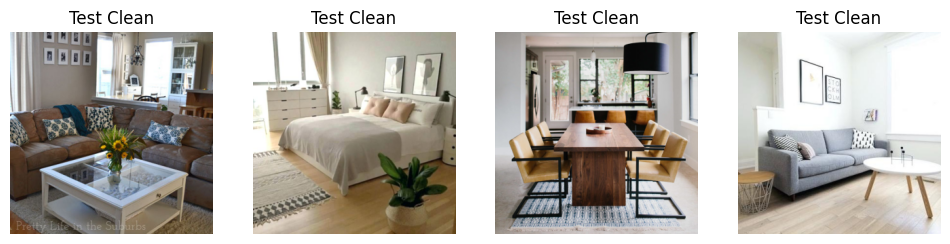

Test Clean 총 이미지 수: 5


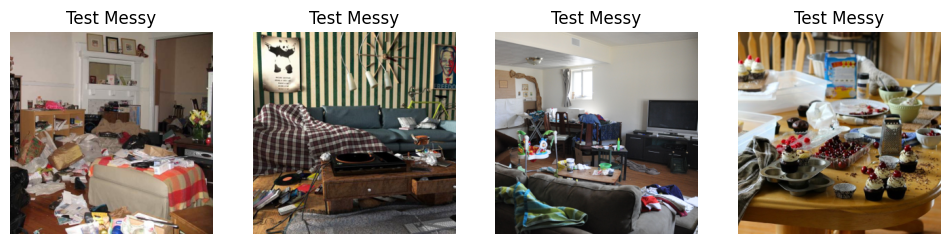

Test Messy 총 이미지 수: 5


In [58]:
# 이미지와 바 그래프 출력
categories = ['Train Clean', 'Train Messy', 'Val Clean', 'Val Messy', 'Test Clean', 'Test Messy']
for category in categories:
    image_paths = glob.glob(f'../실습 파일/1/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

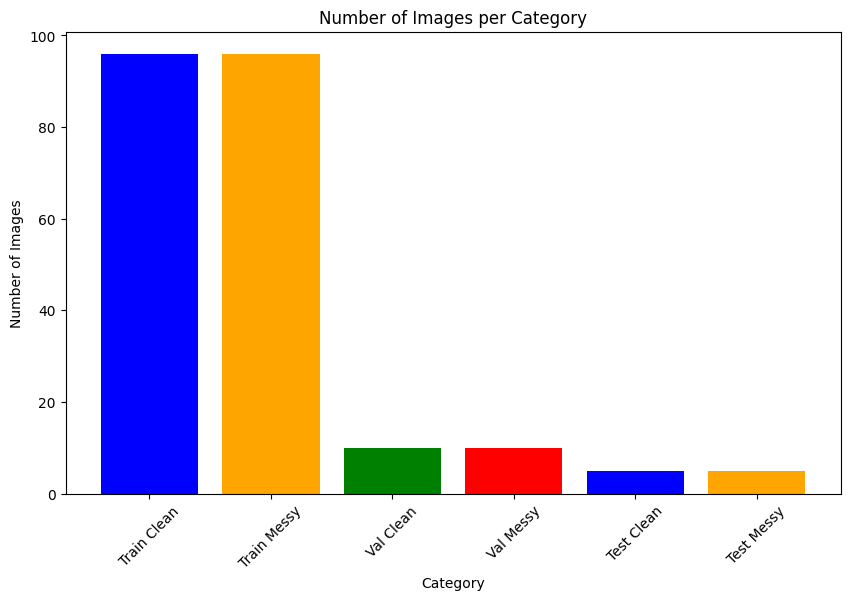

In [59]:
# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'../실습 파일/1/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [60]:
# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 크기 조정
    transforms.ToTensor(), # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 이미지 정규화ㅣ
])


In [61]:
# 데이터 셋 로드
train_dataset = ImageFolder(root='../실습 파일/1/train', transform=transform)
val_dataset = ImageFolder(root='../실습 파일/1/val', transform=transform)
test_dataset = ImageFolder(root='../실습 파일/1/test', transform=transform)

In [62]:
# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)



In [63]:
# AlexNet 모델 정의
net = models.alexnet(pretrained=True)

# 모델 파라미터 출력
print(net)


c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [64]:
# 모델의 모든 파라미터를 고정
for param in net.parameters():
    param.requires_grad = False

In [65]:
# Classifier의 마지막 레이러를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
net.classifier[6] = nn.Linear(4096, 2)

net.classifier[5].requires_grad = True
net.classifier[6].requires_grad = True


In [66]:
# 손실 함수 및 최적화
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.AdamW(net.parameters(), lr=0.0001)

# 학습 및 검증 루프
num_epochs = 20


In [67]:
from lion_pytorch import Lion

optimizer_2 = Lion(net.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-2)

In [68]:
# 정확도 계산 함수
def calculate_accuracy(loader, model):
    """주어진 데이터 로더에 대한 모델의 정확도 계산"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [69]:
# 학습/검증 손실과 검증 정확도를 저장할 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [70]:
net.to(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [71]:
# 학습/검증 손실과 검증 정확도를 저장할 리스트 초기화
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 모델을 디바이스로 이동
net.to(device)


# 학습 및 검증 루프
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_1.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item()
    
    # 매 에포크마다 평균 학습 손실 계산
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)  # 수정된 부분
    
    # 검증 손실 계산
    val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)  # 수정된 부분

    # 훈련 및 검증 정확도 계산
    train_accuracy = calculate_accuracy(train_loader, net)  # 추가된 부분
    val_accuracy = calculate_accuracy(val_loader, net)
    train_accuracies.append(train_accuracy)  # 추가된 부분
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")
        



Epoch 1/20, Train Loss: 0.7193, Val Loss: 0.5746, Train Accuracy: 66.15%, Val Accuracy: 80.00%
Epoch 2/20, Train Loss: 0.5228, Val Loss: 0.4585, Train Accuracy: 83.33%, Val Accuracy: 85.00%
Epoch 3/20, Train Loss: 0.4124, Val Loss: 0.3750, Train Accuracy: 91.67%, Val Accuracy: 90.00%
Epoch 4/20, Train Loss: 0.3323, Val Loss: 0.3139, Train Accuracy: 92.19%, Val Accuracy: 95.00%
Epoch 5/20, Train Loss: 0.2614, Val Loss: 0.2696, Train Accuracy: 94.27%, Val Accuracy: 95.00%
Epoch 6/20, Train Loss: 0.2447, Val Loss: 0.2387, Train Accuracy: 95.83%, Val Accuracy: 95.00%
Epoch 7/20, Train Loss: 0.2169, Val Loss: 0.2152, Train Accuracy: 95.83%, Val Accuracy: 95.00%
Epoch 8/20, Train Loss: 0.1948, Val Loss: 0.1970, Train Accuracy: 95.83%, Val Accuracy: 95.00%
Epoch 9/20, Train Loss: 0.1841, Val Loss: 0.1812, Train Accuracy: 96.35%, Val Accuracy: 95.00%
Epoch 10/20, Train Loss: 0.1587, Val Loss: 0.1684, Train Accuracy: 96.35%, Val Accuracy: 95.00%
Epoch 11/20, Train Loss: 0.1458, Val Loss: 0.1582